In [52]:
import quandl

# Set your API key
quandl.ApiConfig.api_key = 'zs3oRyjDLfSoEpPRFxKJ'

# Get data for a specific dataset
dataset = quandl.get('WIKI/AAPL')  # Example: Apple Inc. stock data

In [53]:
dataset.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio'], axis=1, inplace=True)

In [54]:
import torch

# CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA not available. Using CPU.


In [55]:
df = dataset

In [56]:
df

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
1980-12-12,0.422706,0.424470,0.422706,0.422706,117258400.0
1980-12-15,0.402563,0.402563,0.400652,0.400652,43971200.0
1980-12-16,0.373010,0.373010,0.371246,0.371246,26432000.0
1980-12-17,0.380362,0.382273,0.380362,0.380362,21610400.0
1980-12-18,0.391536,0.393300,0.391536,0.391536,18362400.0
...,...,...,...,...,...
2018-03-21,175.040000,175.090000,171.260000,171.270000,35247358.0
2018-03-22,170.000000,172.680000,168.600000,168.845000,41051076.0
2018-03-23,168.390000,169.920000,164.940000,164.940000,40248954.0


## RNN

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN


In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']].values)

X = []
y = []
for i in range(50, len(scaled_data)):
    X.append(scaled_data[i-50:i, :])
    y.append(scaled_data[i, 3])  # Adj. Close

X, y = np.array(X), np.array(y)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [59]:
model = Sequential()

model.add(SimpleRNN(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(SimpleRNN(units=50, activation='relu', return_sequences=False))


model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            2800      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7901 (30.86 KB)
Trainable params: 7901 (30.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
234/234 [==============================] - 5s 13ms/step - loss: 6.3044e-05
Epoch 2/25
234/234 [==============================] - 3s 12ms/step - loss: 6.6612e-06
Epoch 3/25
234/234 [==============================] - 3s 11ms/step - loss: 4.8215e-06
Epoch 4/25
234/234 [==============================] - 3s 11ms/step - loss: 3.2500e-06
Epoch 5/25
234/234 [==============================] - 3s 12ms/step - loss: 3.6275e-06
Epoch 6/25
234/234 [==============================] - 3s 11ms/step - loss: 3.4876e-06
Epoch 7/25
234/234 [==============================] - 3s 12ms/step - loss: 4.9044e-06
Epoch 8/25
234/234 [==============================] - 3s 14ms/step - loss: 3.1035e-06
Epoch 9/25
234/234 [==============================] - 3s 12ms/step - loss: 3.3209e-06
Epoch 10/25
234/234 [==============================] - 8s 33ms/step - loss: 3.2838e-06
Epoch 11/25
234/234 [==============================] - 3s 12ms/step - loss: 2.9742e-06
Epoch 12/25
234/234 [==============================]

59/59 [==============================] - 1s 7ms/step
Mean Squared Error: 36.7175693033214


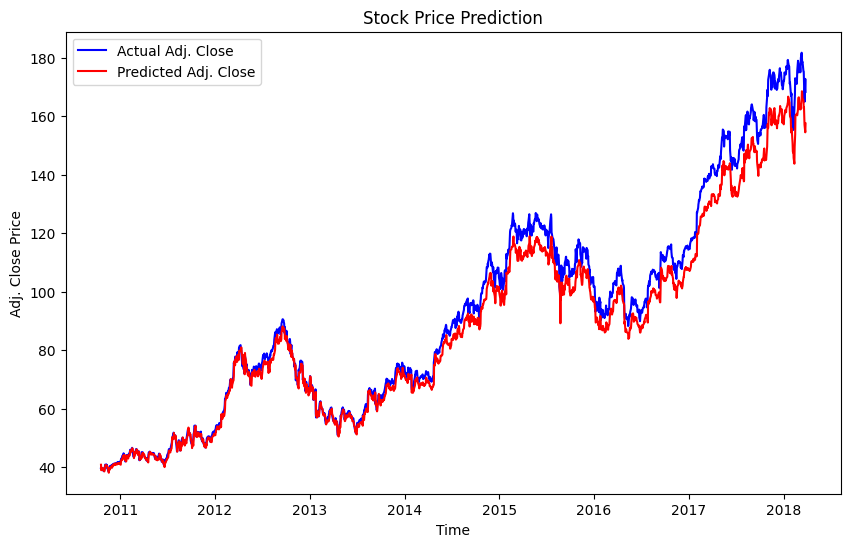

In [62]:
predicted_stock_price = model.predict(X_test)


predicted_stock_price_full = np.zeros((len(predicted_stock_price), 5))
predicted_stock_price_full[:, 3] = predicted_stock_price[:, 0]  


predicted_stock_price_full = scaler.inverse_transform(predicted_stock_price_full)
predicted_stock_price = predicted_stock_price_full[:, 3]


actual_stock_price = df.iloc[train_size + 50:, 3].values  
dates = df.index[train_size + 50:]


mse = mean_squared_error(actual_stock_price, predicted_stock_price)
print(f'Mean Squared Error: {mse}')


plt.figure(figsize=(10,6))
plt.plot(dates, actual_stock_price, color='blue', label='Actual Adj. Close')
plt.plot(dates, predicted_stock_price, color='red', label='Predicted Adj. Close')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close Price')
plt.legend()
plt.show()



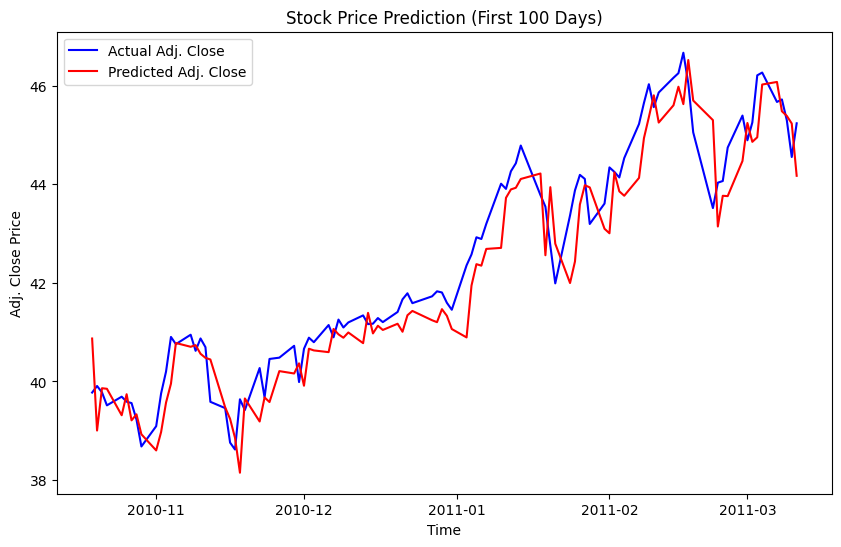

In [63]:
num_days_to_plot = min(100, len(actual_stock_price))

plt.figure(figsize=(10,6))
plt.plot(dates[:num_days_to_plot], actual_stock_price[:num_days_to_plot], color='blue', label='Actual Adj. Close')
plt.plot(dates[:num_days_to_plot], predicted_stock_price[:num_days_to_plot], color='red', label='Predicted Adj. Close')
plt.title('Stock Price Prediction (First 100 Days)')
plt.xlabel('Time')
plt.ylabel('Adj. Close Price')
plt.legend()
plt.show()

## LSTM

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [65]:

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(LSTM(units=50, return_sequences=False))


model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            11200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
234/234 [==============================] - 16s 34ms/step - loss: 3.6284e-05
Epoch 2/25
234/234 [==============================] - 9s 37ms/step - loss: 6.5818e-06
Epoch 3/25
234/234 [==============================] - 8s 36ms/step - loss: 5.8522e-06
Epoch 4/25
234/234 [==============================] - 8s 35ms/step - loss: 5.0530e-06
Epoch 5/25
234/234 [==============================] - 8s 36ms/step - loss: 5.2015e-06
Epoch 6/25
234/234 [==============================] - 8s 33ms/step - loss: 4.3406e-06
Epoch 7/25
234/234 [==============================] - 7s 31ms/step - loss: 4.4850e-06
Epoch 8/25
234/234 [==============================] - 8s 35ms/step - loss: 4.3919e-06
Epoch 9/25
234/234 [==============================] - 8s 32ms/step - loss: 3.5276e-06
Epoch 10/25
234/234 [==============================] - 16s 67ms/step - loss: 3.4071e-06
Epoch 11/25
234/234 [==============================] - 20s 88ms/step - loss: 4.0270e-06
Epoch 12/25
234/234 [============================

59/59 [==============================] - 2s 12ms/step
Mean Squared Error: 5.748880142793921


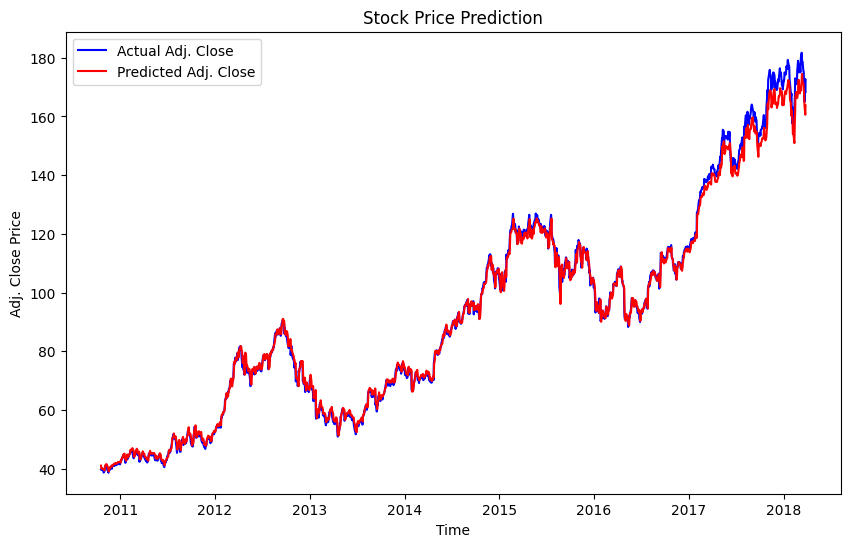

In [68]:

predicted_stock_price = model.predict(X_test)


predicted_stock_price_full = np.zeros((len(predicted_stock_price), 5))
predicted_stock_price_full[:, 3] = predicted_stock_price[:, 0]  


predicted_stock_price_full = scaler.inverse_transform(predicted_stock_price_full)
predicted_stock_price = predicted_stock_price_full[:, 3]

actual_stock_price = df.iloc[train_size + 50:, 3].values  
dates = df.index[train_size + 50:]


mse = mean_squared_error(actual_stock_price, predicted_stock_price)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(10,6))
plt.plot(dates, actual_stock_price, color='blue', label='Actual Adj. Close')
plt.plot(dates, predicted_stock_price, color='red', label='Predicted Adj. Close')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close Price')
plt.legend()
plt.show()


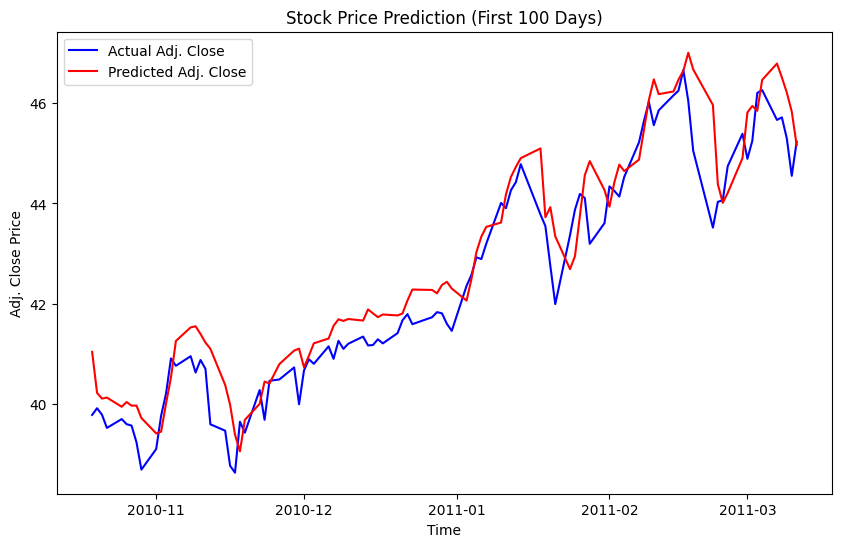

In [69]:
num_days_to_plot = min(100, len(actual_stock_price))

plt.figure(figsize=(10,6))
plt.plot(dates[:num_days_to_plot], actual_stock_price[:num_days_to_plot], color='blue', label='Actual Adj. Close')
plt.plot(dates[:num_days_to_plot], predicted_stock_price[:num_days_to_plot], color='red', label='Predicted Adj. Close')
plt.title('Stock Price Prediction (First 100 Days)')
plt.xlabel('Time')
plt.ylabel('Adj. Close Price')
plt.legend()
plt.show()

## Stacking

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor


In [80]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']].values)


X = []
y = []
for i in range(50, len(scaled_data)):
    X.append(scaled_data[i-50:i, :].flatten())  
    y.append(scaled_data[i, 3])  

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [78]:
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=42)),
    ('svr', SVR(C=1, gamma='auto')),
    ('gbr', GradientBoostingRegressor(n_estimators=10, random_state=42))
]


meta_model = Ridge()

stacked_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_model)


In [81]:

stacked_regressor.fit(X_train, y_train)


StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(n_estimators=10,
                                                     random_state=42)),
                              ('svr', SVR(C=1, gamma='auto')),
                              ('gbr',
                               GradientBoostingRegressor(n_estimators=10,
                                                         random_state=42))],
                  final_estimator=Ridge())

Test Mean Squared Error: 100885019625606.98
Train Mean Squared Error: 52870545870477.15


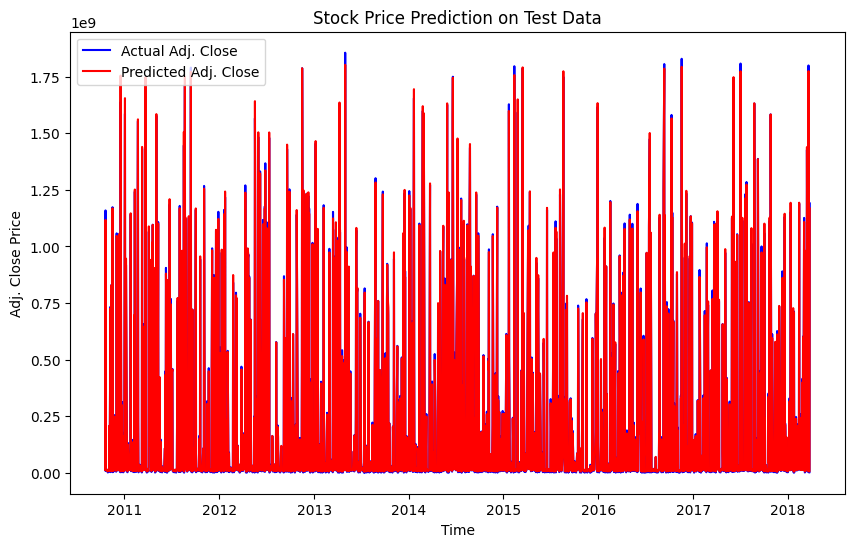

In [83]:

y_pred_test = stacked_regressor.predict(X_test)
y_pred_train = stacked_regressor.predict(X_train)


y_pred_test = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_test), 4)), y_pred_test.reshape(-1,1)), axis=1))[:,4]
y_test_actual = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 4)), y_test.reshape(-1,1)), axis=1))[:,4]

y_pred_train = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_train), 4)), y_pred_train.reshape(-1,1)), axis=1))[:,4]
y_train_actual = scaler.inverse_transform(np.concatenate((np.zeros((len(y_train), 4)), y_train.reshape(-1,1)), axis=1))[:,4]


mse_test = mean_squared_error(y_test_actual, y_pred_test)
print(f'Test Mean Squared Error: {mse_test}')


mse_train = mean_squared_error(y_train_actual, y_pred_train)
print(f'Train Mean Squared Error: {mse_train}')

dates_test = df.index[len(df) - len(y_test):]
plt.figure(figsize=(10,6))
plt.plot(dates_test, y_test_actual, color='blue', label='Actual Adj. Close')
plt.plot(dates_test, y_pred_test, color='red', label='Predicted Adj. Close')
plt.title('Stock Price Prediction on Test Data')
plt.xlabel('Time')
plt.ylabel('Adj. Close Price')
plt.legend()
plt.show()


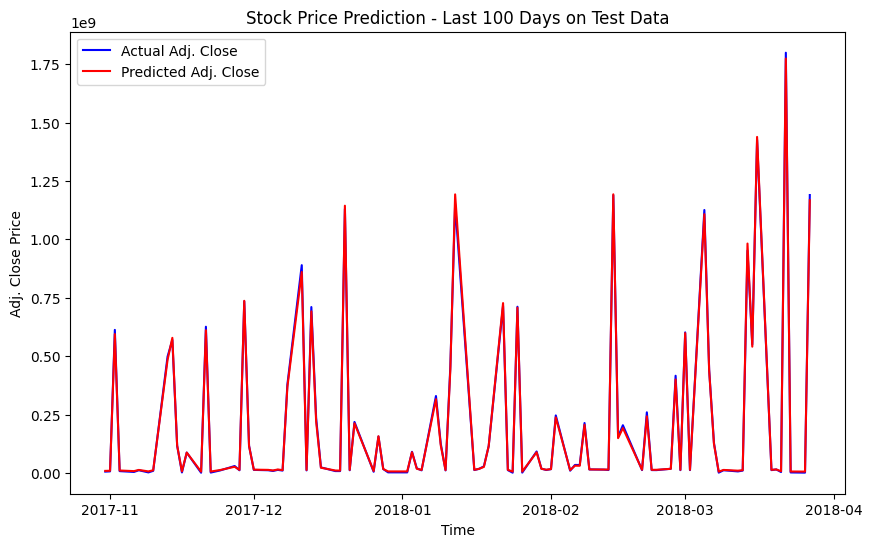

In [76]:
last_100_days = 100
y_pred_test_last_100 = y_pred_test[-last_100_days:]
y_test_actual_last_100 = y_test_actual[-last_100_days:]
dates_test_last_100 = dates_test[-last_100_days:]


plt.figure(figsize=(10,6))
plt.plot(dates_test_last_100, y_test_actual_last_100, color='blue', label='Actual Adj. Close')
plt.plot(dates_test_last_100, y_pred_test_last_100, color='red', label='Predicted Adj. Close')
plt.title('Stock Price Prediction - Last 100 Days on Test Data')
plt.xlabel('Time')
plt.ylabel('Adj. Close Price')
plt.legend()
plt.show()
